Open Source Software Project
========================

Traveling Santa 2018 - Prime Paths
-----------------------------------------

Author: Jijong Park, jjp9303kr@icloud.com  
Supervisor: In-seop Na, ypencil@hanmail.net  
Starting Project 2019.1.7  

based on Andre Sionek, Object Oriented Santa’s Route + Concorde Solver, https://www.kaggle.com/andresionek/object-oriented-santa-s-route-concorde-solver

In [1]:
# import libs
import io
import base64
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from concorde.tsp import TSPSolver

import pylab as pl
from matplotlib import collections as mc
from IPython.display import display, HTML

City class
------------

입력 데이터로부터 받을 수 있는 데이터
x: x축 좌표
y: y축 좌표
id: 도시 번호

두 좌표 정보를 조합해 coord: (x, y)의 터플형 데이터를 만들 수 있다.

어떤 도시에 한 번 방문 했음을 표시하기 위해 boolean 타입 is_visited, 초기값 False

어떤 도시가 프라임도시인지 체크하기 위해 boolean 타입 is_prime 선언 후 check_prime()을 통해 초기화

__init__(): 객체 초기화
check_prime(): 도시 ID가 소수인지 판단하여 프라임도시 여부 확인
visit(): 도시를 방문하고 방문 여부 True로 변경
__repr__(): 객체의 정보 출력
    CityId: 도시 번호
    Coordinates: 좌표정보
    Is prime: 프라임(소수) 도시 여부
    Is visited: 방문 여부

In [2]:
# City class
class City:   
    def __init__(self, id_, x, y):
        self.x = x
        self.y = y
        self.coord = (x, y)
        self.id = id_
        self.is_visited = False
        self.is_prime = self.check_prime()
    
    # 프라임 도시인지 체크
    def check_prime(self):
        if self.id % 2 == 0 and self.id > 2: 
            return False
        return all(self.id % i for i in range(3, int(math.sqrt(self.id)) + 1, 2))
    
    # 방문한 곳 체크
    def visit(self):
        self.is_visited = True
        
    # City 객체의 정보를 출력하는 용도
    def __repr__(self):
        fmt_str = 'CityId: {} \nCoordinates: {}\nIs prime: {}\nIs visited: {}'
        return fmt_str.format(self.id, self.coord, self.is_prime, self.is_visited)

World class
-
Dictionary 컬렉션

In [3]:
class World:
    def __init__(self):
        self.cities = dict()
        self.df = pd.DataFrame()
    
    # City 객체 하나를 World에 추가
    def add(self, city):
        if isinstance(city, City):
            # checks if the object type added to the world is correct
            self.cities[city.id] = city
        else:
            raise TypeError ('city must be a "__main__.City" object!')
        self.update_df()
    
    # City 객체 하나를 World에서 제거
    def remove_by_id(self, id_):
        self.cities.pop(id_)
    
    # 데이터프레임에서 도시 리스트 불러오기
    def bulk_add_city(self, dataframe):
        dataframe['city'] = dataframe.apply(lambda x: City(x.iloc[0], x.iloc[1], x.iloc[2]), axis=1)
        dataframe = dataframe.drop(['X','Y'], axis=1)
        dataframe = dataframe.set_index('CityId')
        cities = dataframe.to_dict()['city']
        self.cities.update(cities)
        self.update_df()
    
    # Gets the quantity of cities in the world
    def size(self):
        return self.df.shape[0]
    
    # World에서 프라임 도시 얻기
    def primes(self):
        return [c for idx, c in self.cities.items() if c.is_prime]
    
    # World에서 프라임 도시가 아닌 도시 얻기
    def nonprimes(self):
        return [c for idx, c in self.cities.items() if not c.is_prime]
    
    # 북극(시작점, CityId == 0) 얻기
    def north_pole(self):
        return self.cities[0]
    
    # World에 있는 모든 City의 Id 값(key) 얻기
    def ids(self):
        return list(self.cities.keys())
    
    # Id(key) 값으로 City 얻기
    def get_city(self, id_):
        return self.cities[id_]
    
    # 도시 좌표를 dataframe으로 가져오기
    def update_df(self):
        dataframe = pd.DataFrame.from_dict(world.cities, orient='index', columns=['city'])
        dataframe['x'] = dataframe.apply(lambda x: x.iloc[0].x, axis=1)
        dataframe['y'] = dataframe.apply(lambda x: x.iloc[0].y, axis=1)
        dataframe['id'] = dataframe.apply(lambda x: x.iloc[0].id, axis=1)
        dataframe['is_prime'] = dataframe.apply(lambda x: x.iloc[0].is_prime, axis=1)
        self.df = dataframe
    
    # World 그래프 그리기. 북극을 빨간색으로 표시하고, 옵션으로 프라임 도시를 파란 색으로 표시
    def plot(self, show_primes=False):
        self.df.plot.scatter(x='x', y='y', s=0.07, figsize=(15, 10), c='green', alpha=0.6)

        if show_primes:
            coords = self.df[self.df['is_prime']]
            plt.scatter(x=coords.x, y=coords.y, c='blue', s=0.1, alpha=0.6)
        
        plt.scatter(self.north_pole().x, self.north_pole().y, c='red', s=16)
        plt.axis('off')
        
        return plt.show()

데이터프레임 불러오기

In [4]:
df = pd.read_csv('./data/cities.csv')
df.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [5]:
df.shape # the dataset shape

(197769, 3)

In [6]:
world = World() # creates a new empty world
world.cities

{}

In [7]:
world.bulk_add_city(df) # adds all cities from the dataframe into the world

In [8]:
print("총 도시 갯수:", world.size()) # 도시의 총 갯수

총 도시 갯수: 197769


In [9]:
print("북극 좌표:", world.north_pole().coord) # 북극(CityId == 0)의 좌표 확인

북극 좌표: (316.83673906150904, 2202.34070733524)


In [10]:
print("프라임 도시 갯수:", len(world.primes())) # 프라임 도시의 갯수

프라임 도시 갯수: 17804


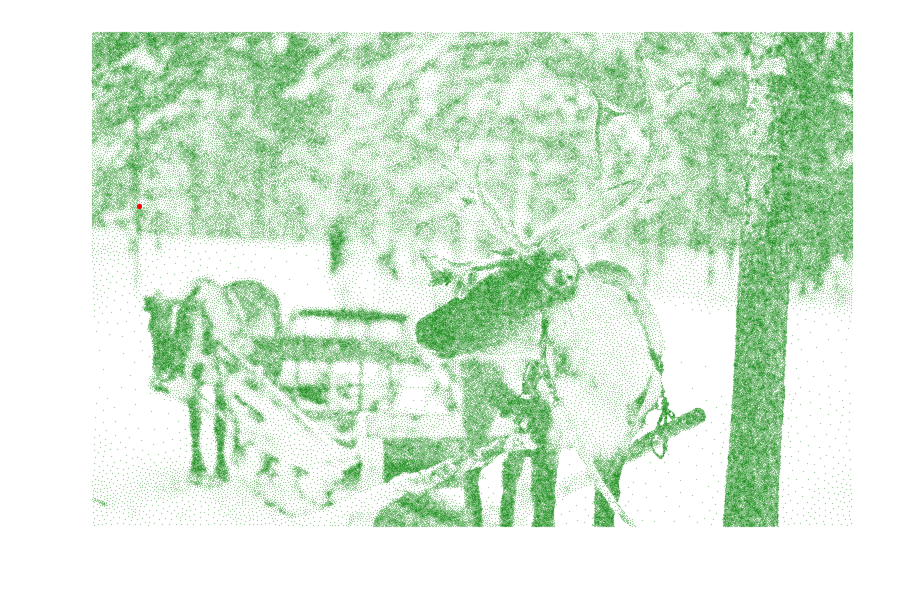

In [11]:
world.plot() # 그래프

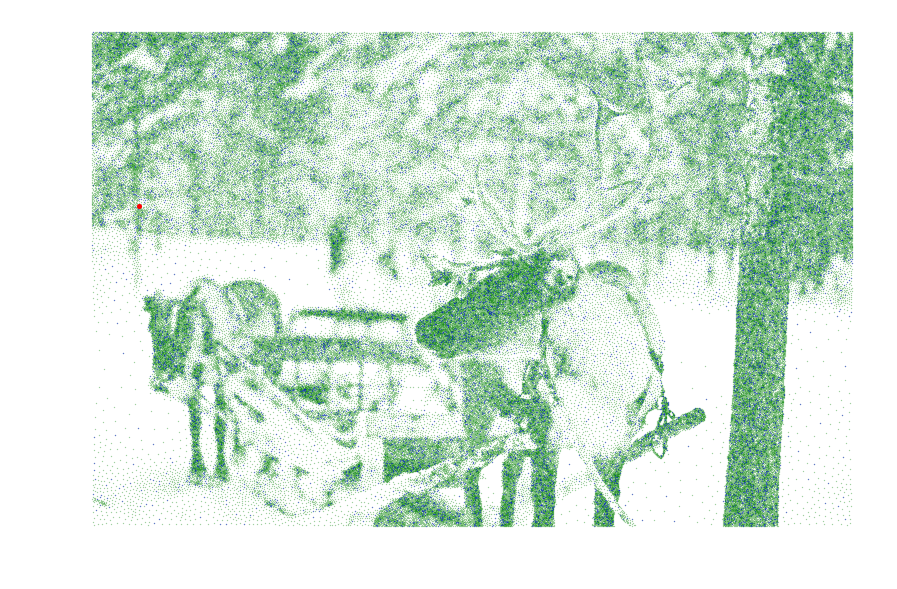

In [12]:
world.plot(show_primes=True) # 프라임도시를 별도 색으로 표기한 그래프

경로 찾기
---------

In [13]:
class Route():
    def __init__(self, world):
        # Init path with just the North Pole
        self.world = world
        self.stops = [self.world.north_pole()]
        self.tenth_steps = []
        self.prime_tenth_steps = self.get_prime_tenth_steps()
    
    # 두 도시간 2D 유클리드 거리 계산
    @staticmethod
    def distance(a, b):
        return math.sqrt((a.x - b.x) ** 2 + (a.y - b.y) ** 2)
    
    # Calculates the number of stops in the path
    def size(self):
        return len(self.stops)
    
    # Add stop to path
    def add(self, ids):
        if isinstance(ids, type(list())):
            for id_ in ids:
                self.stops.append(self.world.get_city(id_))
        elif isinstance(ids, type(int())):
            self.stops.append(self.world.get_city(ids))
    
    # Adds all cities in the world to the route
    def add_world(self):
        self.add(list(range(1, self.world.size())))
    
    # 패널티를 포함한 전체 경로의 비용 계산
    def cost(self):
        dist = 0
        l = self.size()
        for idx, stop in enumerate(self.stops):
            curr_ = stop
            step_number = idx + 1
            if step_number < l:
                next_ = self.stops[step_number]
            if step_number % 10 == 0 and not curr_.is_prime:
                dist += self.distance(curr_, next_) * 1.1
            else:
                dist += self.distance(curr_, next_)
        return dist
    
    # 패널티를 제외한 경로의 비용 계산
    def euclidian_cost(self):
        dist = 0
        l = self.size()
        for idx, stop in enumerate(self.stops):
            curr_ = stop
            step_number = idx + 1
            if step_number < l:
                next_ = self.stops[step_number]
            dist += self.distance(curr_, next_)
        return dist
    
    # 프라임도시에 가지 않아서 생긴 패널티 총량
    def penalty(self):
        return self.cost() - self.euclidian_cost()
    
    # 10번째마다 방문한 도시들 구하기
    def get_tenth_steps(self):
        self.tenth_steps = [c for s,c in enumerate(self.stops) if (s + 1) % 10 == 0]
        return self.tenth_steps
    
    # 10번째마다 방문한 도시 중 프라임 도시 구하기
    def get_prime_tenth_steps(self):
        primes = self.world.primes()
        self.prime_tenth_steps = [c for c in self.tenth_steps if c in primes]
        return self.prime_tenth_steps
    
    # 방문 경로대로 순차 정렬된 도시 리스트 얻기
    def get_ids(self):
        return [c.id for c in self.stops]

    # 콩코드로 문제 풀이, 패널티 제외
    def concorde(self, time):
        x = [c.x for c in self.stops[:-1]]
        y = [c.y for c in self.stops[:-1]]

        # Instantiate solver
        solver = TSPSolver.from_data(x, y, norm="EUC_2D")
        
        # solve
        # time_bound: 시간 제한. 다만 어째선지 시간제한을 무시하는 경우가 있다.
        tour_data = solver.solve(time_bound=float(time), verbose=True, random_seed=42)
        
        # 콩코드 솔루션을 기반으로 루트 재정렬
        order = np.append(tour_data.tour,[0])
        new_route = [self.stops[i] for i in order]
        self.stops = new_route
    
    # 경로를 그래프로 그리기
    def plot(self, show_primes=False, show_10th_step=False, show_intersection=False):
        lwidth, lalpha = 0.4, 0.6
        lines = [[self.stops[i].coord,self.stops[i + 1].coord] for i in range(0, self.size() - 1)]
        lc = mc.LineCollection(lines, linewidths=lwidth, alpha=lalpha, colors='red')
        fig, ax = pl.subplots(figsize=(20,20))
        
        ax.set_aspect('equal')
        ax.add_collection(lc)
        ax.autoscale()   
        
        if show_primes:
            # get coords of prime cities
            coords = self.world.df[self.world.df['is_prime']]
            # plot
            pc = plt.scatter(x=coords.x, y=coords.y, c='green', s=3, alpha=0.3) 
            ax.add_collection(pc)
        
        if show_10th_step:
            # get coords of each 10th stop
            coords = [c.coord for c in self.tenth_steps]
            coords = pd.DataFrame(coords, columns=['x','y'])
            # plot 
            pc = plt.scatter(x=coords.x, y=coords.y, c='blue', s=3, alpha=0.3) 
            ax.add_collection(pc)
        
        if show_intersection:
            # get coords of each 10th stop
            coords = [c.coord for c in self.prime_tenth_steps]
            coords = pd.DataFrame(coords, columns=['x','y'])
            # plot 
            pc = plt.scatter(x=coords.x, y=coords.y, c='black', s=4, alpha=0.5)
            ax.add_collection(pc)
            
        coords = self.world.north_pole() # 북극을 보라색 점으로 표시
        np = plt.scatter(x=coords.x, y=coords.y, c='purple', s=16)
        ax.add_collection(np)
    
    # 외부 솔루션 불러오기용
    def load(self, path):
        df = pd.read_csv(path)
        ids = df['Path'].values.tolist()
        self.stops = []
        for id_ in ids:
            self.stops.append(self.world.get_city(id_))
    
    # 경로 정보를 csv파일로 내보내기
    def submit(self, filename):
        dataframe = pd.DataFrame(self.stops, columns=['city'])
        dataframe['Path'] = dataframe.apply(lambda x: x.iloc[0].id, axis=1).astype(int)
        dataframe[['Path']].to_csv(filename, index=False)

In [14]:
route = Route(world)
route.stops

[CityId: 0.0 
 Coordinates: (316.83673906150904, 2202.34070733524)
 Is prime: True
 Is visited: False]

In [15]:
route.stops[0].id, route.stops[0].coord

(0.0, (316.83673906150904, 2202.34070733524))

In [16]:
route.add_world() # 경로에 모든 도시 추가(world에 추가되어 있다)
#route.add(0) # 마지막 목적지 북극을 경로에 추가

In [17]:
#print("정렬되지 않은 순차 루트 비용:", route.cost()) # id 오름차순 경로

In [18]:
#route.plot()

In [ ]:
#route.submit('index_submission.csv')

콩코드 풀이

In [ ]:
route.concorde(600.0) # 콩코드로 경로 계산(time_bound 인수)

In [ ]:
print("콩코드 루트의 비용:", route.cost()) # 패널티 포함 전체 경로 비용

In [ ]:
print("콩코드 루트의 비용(패널티 제외):", route.euclidian_cost()) # 패널티 제외 전체 경로 비용

In [ ]:
print("패널티 비용:", route.penalty()) # 패널티 총량

In [ ]:
route.get_tenth_steps() # 10번째마다 방문한 도시 목록
route.get_prime_tenth_steps() # 그 중 프라임도시인 목록
print("프라임 도시 갯수:", len(world.primes())) # 프라임 도시의 갯수
print("10번째 도시 수:", len(route.tenth_steps))
print("10번째 도시 중 프라임 도시:", len(route.prime_tenth_steps))
prime_per = (len(route.prime_tenth_steps) / len(route.tenth_steps)) * 100 # 10번째마다 방문한 도시가 프라임도시인 확률
print("10번째 방문 도시가 프라임도시인 확률: %.4f%%" %prime_per)
prime_precision = (len(route.prime_tenth_steps) / len(world.primes())) * 100
print("프라임도시 적중률: %.4f%%" %prime_precision)

In [ ]:
route.plot()

In [ ]:
route.plot(show_primes=True)

In [ ]:
route.plot(show_10th_step=True)

In [ ]:
route.plot(show_intersection=True)

In [ ]:
route.submit('concorde_submission.csv')